# Long term stability of N-body simulations: the case of Trappist-1
[TRAPPIST-1](https://en.wikipedia.org/wiki/TRAPPIST-1) is a system made of seven Earth-sized planets, orbiting closely around a small ultra-cool dwarf with periods forming a near-resonant chain. The system is of particular interest as it is considered as a candidate to host extraterrestrial life and it is relatively close to our solar system (∼40 light years).

Here we show how to use *heyoka.py* to setup a simulation to study the long-term stability of the system. For this purpose we will simulate the N-body dynamics of the system directly in Cartesian coordinates and in an inertial reference frame, the equations of motion (EOM) being:

$$
\left\{
\begin{aligned}
\frac{d^2x_i}{dt^2} &= -G \sum_{i\ne j}^N \frac {m_j (x_i-x_j)}{\left[{(x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2}\right]^\frac 32} \\
\frac{d^2y_i}{dt^2} &= -G \sum_{i\ne j}^N \frac {m_j (y_i-y_j)}{\left[{(x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2}\right]^\frac 32} \\
\frac{d^2z_i}{dt^2} &= -G \sum_{i\ne j}^N \frac {m_j (z_i-z_j)}{\left[{(x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2}\right]^\frac 32} 
\end{aligned}
\right. \qquad \qquad \rightarrow i = 1..N
$$

To build this system of equations we can use heyoka built-in ``make_nbody_sys`` which will implement for us the equations of motion above. Our main concern is, thus, to generate sets of initial conditions that are compatible with the Earth-based astronomical observations made and simulate a bunch of them in parallel.

NOTE: We will not use in this notebook *heyoka.py*'s vectorization capabilities and we will, instead, only parallelise using multiple threads.

NOTE: Thread parallelism is possible as the *heyoka.py* Taylor integrator releases the python GIL.

Let us begin with importing the needed dependencies:

In [1]:
# core imports
import heyoka as hey
import numpy as np
import pykep as pk

# plots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# misc
from copy import deepcopy
from multiprocessing.pool import ThreadPool
from scipy.optimize import newton

The first thing one must do is to collect the physical information on the system. For this purpose we refer to the paper from [Agol et al.](https://arxiv.org/pdf/2010.01074.pdf) and we collect and store the various observations for the Trappist system. We indicate with a small ``s`` the measurement error:

In [2]:
# Cavendish constant (kg m^3/s^2)
G = 6.67430E-11
# Sun_mass (kg)
SM = 1.989E30
# Earth mass (kg)
EM = 5.972E24
# Mass of the Trappist-1 star
MS = 0.0898 * SM
MSs = 0.0023
# Starting epoch of the simulation
t_start = 7257.93115525 * pk.DAY2SEC
# Masses of the Earth sized planets 
mu =  np.array([1.3771,1.3105,0.3885,0.6932,1.0411,1.3238,0.3261])
mus = np.array([0.0593,0.0453,0.0074,0.0128,0.0155,0.0171,0.0186])
# Orbital parameters for the Earth sized planets 
P = np.array([1.510826, 2.421937, 4.049219, 6.101013, 9.207540,12.352446,18.772866]) * pk.DAY2SEC
Ps = np.array([0.000006,0.000018,0.000026,0.000035,0.000032,0.000054,0.000214]) * pk.DAY2SEC
t0 = np.array([7257.55044,7258.58728,7257.06768,7257.82771,7257.07426,7257.71462,7249.60676]) * pk.DAY2SEC
t0s = np.array([0.00015,0.00027,0.00067,0.00041,0.00085,0.00103,0.00272]) * pk.DAY2SEC
ecosw = np.array([-0.00215, 0.00055,-0.00496, 0.00433,-0.00840, 0.00380,-0.00365])
ecosws =  np.array([0.00332,0.00232,0.00186,0.00149,0.00130,0.00112,0.00077])
esinw = np.array([ 0.00217, 0.00001, 0.00267,-0.00461,-0.00051, 0.00128,-0.00002])
esinws = np.array([0.00244,0.00171,0.00112,0.00087,0.00087,0.00070,0.00044])

# We put everything in a dictionary for convenience
data = dict()
data["MS"] = MS; data["MSs"] = MSs; data["mu"] = mu; data["mus"] = mus; data["P"] = P; data["Ps"] = Ps; 
data["t0"] = t0; data["t0s"] = t0s; data["t_start"] = t_start; data["ecosw"] = ecosw; data["ecosws"] = ecosws; 
data["esinw"] = esinw; data["esinws"] = esinws; data["G"] = G; data["m_earth"] = EM; data["m_sun"] = SM

We can now generate plausible Trappist systems having physical properties that are compatible with the astronomical observation, we thus define a ``trappist_generator`` that returns the mass and position of all bodies in the Trappist-1 system (star and planets). Since we are at it we make the generator able to generate ``N`` plausible systems.

In [3]:
def trappist_generator(N, trappist_data):
    G, m_earth, m_sun = data["G"], data["m_earth"], data["m_sun"]
    retval_ic = []
    retval_m = []
    
   
    for i in range(N):
        # First we generate the stellar mass
        m_star = data["MS"] + data["MSs"] * (np.random.random()*2-1)

        # Then we generate masses for the planets
        m_pl = (data["mu"] + data["mus"] * (np.random.random()*2-1))
        m_pl = m_pl * m_earth * m_star / (m_sun * 0.09)

        # And compute the Jacobi masses "The Jacobi mass of planet i 
        # includes also the masses of all objects with a smaller 
        # semi-major axis."
        m_jacobi = np.cumsum(m_pl)

        # Then we generate the periods P
        P_pl = data["P"] + data["Ps"] * (np.random.random()*2-1)

        # And compute the semi-major axes from them
        a_pl = (P_pl / 2. / np.pi)**2 * G * (m_jacobi + m_star)
        a_pl = a_pl**(1./3.)
        #a_pl = a_pl  * (1 + pert*(np.random.random(7)*2-1))
        # Then we generate the ecos, esin 
        ecosw = data["ecosw"] + data["ecosws"] * (np.random.random()*2-1) 
        esinw = data["esinw"] + data["esinws"] * (np.random.random()*2-1) 

        # And compute eccentricites and argument of peristars
        e_pl = np.sqrt(ecosw**2 + esinw**2)
        w_pl = np.arctan2(esinw, ecosw)
        #e_pl = e_pl * (1 + pert*(np.random.random(7)*2-1))
        #w_pl = w_pl * (1 + pert*(np.random.random(7)*2-1))

        # And compute the mean anomalies at transit
        ni_pl_t = np.pi/2 - w_pl
        E_pl_t = np.tan(ni_pl_t/2) * np.sqrt((1 - e_pl)/(1 + e_pl))
        E_pl_t = np.arctan(E_pl_t)
        E_pl_t = E_pl_t * 2
        M_pl_t = E_pl_t - E_pl_t * np.sin(E_pl_t)

        # And we set inclinations and RAAN accordingly
        RAAN_pl = np.zeros(7)
        incl_pl = np.ones(7) * np.pi/2
        #incl_pl = incl_pl * (1 + pert*(np.random.random(7)*2-1))

        # Then we generate the t0
        t0_pl = data["t0"] + data["t0s"] * (np.random.random()*2-1) 

        # And we compute the mean anomalies
        M_pl = M_pl_t - ((t0_pl - data["t_start"]) * np.pi * 2) / P_pl


        # With all of the orbital parameters defined we can instantiate the ICs
        ic_tr = [0,0,0,0,0,0]
        for j in range(7):
            # Newton method to find E from M
            E = newton(lambda E, e, M: E-e*np.sin(E) - M, M_pl[j] + e_pl[j]*np.cos(M_pl[j]), args = (e_pl[j], M_pl[j]))
            r,v = pk.par2ic([a_pl[j], e_pl[j], incl_pl[j], RAAN_pl[j], w_pl[j], E], G * m_star)
            ic_tr = ic_tr + list(r) + list(v)
        ic_tr = np.array(ic_tr)

        # Assemble the return masses into one 
        m_tr = [m_star] + list(m_pl)
        m_tr = np.array(m_tr)

        # And place the star so that the COM is at the origin
        for j in range(6):
            ic_tr[0+j] = - sum(ic_tr[6+j::6]*(m_tr[1:] / m_tr[0])) 
            
        retval_ic.append(ic_tr)
        retval_m.append(m_tr)
    return retval_m, retval_ic


and we have a first quick look at the resulting orbits of one random instance:

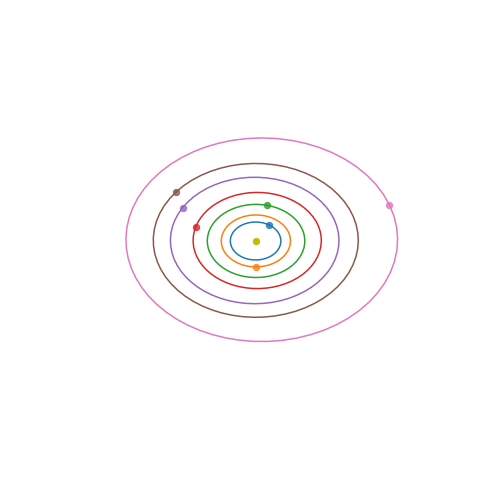

In [4]:
# Plots the trappist system
def plot_trappist(state, mu, axes = None):
    letter = ["s", "a", "b", "c", "d", "e", "f", "g", "h"]
    colors = ["y", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    if axes is None:
        fig = plt.figure(figsize=(7,7))
        axes = fig.add_subplot(111, projection='3d', aspect='auto')
    for i in range(1,8):
        el = pk.ic2par(state[i*6:3+i*6], state[3+i*6:6+i*6], mu)
        pla = pk.planet.keplerian(pk.epoch(0), el, mu, 1., 1., 1. , "Trappist-1"+letter[i])
        pk.orbit_plots.plot_planet(pla, axes=axes, color=colors[i])
    plt.axis('off')
    plt.tight_layout()
    axes.view_init(elev=0., azim=90.)
    axes.scatter(0,0,0,s=40,c='y')
    return axes

masses, state = trappist_generator(1, data)
plot_trappist(state[0], masses[0][0]*G);

We are now ready to define the details of the experiment which will simulate in parallel a number of plausible Trappist-1 systems. 

In [5]:
# Number of parallel processes (i.e. set this to the number of your CPUs).
nproc = 3
# Number of instances of the problem (i.e. plausible Trappist-1 systems we want to generate). 
# This should be equal or larger than the number of parallel processes.
ninst = 3
# Final integration time in yr. (i.e. for 10Myr use 10000000)
final_time_yr = 1000
# N_log number of logged points (uniformly distributed over the integration time)
N_log=50
# Linear schedule
times = np.linspace(1,final_time_yr, N_log)

print("Number of final files that will be generated: {:d}".format(N_log*ninst+ninst))
# We generate the various trappist systems
m, ic = trappist_generator(ninst, data)

Number of final files that will be generated: 153


We define the code that will run in each separate thread. Since this type of simulation may also take days (e.g. when we look at 10Myr evolutions) we use files to log the results and return data from the various threads:

In [6]:
# This will simulate, monitor and log the i-th initial condition
def runner(i):
    # Generates the EOMs
    ode_sys = hey.make_nbody_sys(8, Gconst = G, masses = m[i])
    # Generates the Taylor integrator
    ta = hey.taylor_adaptive(ode_sys, ic[i], high_accuracy=True, tol=1e-18, compact_mode=False)
    
    def data_saver(j, state):           
            np.save('trappist1_{}_{:05d}.npy'.format(i,j), state)
    # Its good practice to put this in a try catch block, even though it should not be necessary
    try:
        np.save('trappist1_m_{}.npy'.format(i), m[i])
        data_saver(0, ic[i])
        for j in range(0,N_log):
            oc, _, _, nsteps = ta.propagate_until(times[j] * 365.25 * pk.DAY2SEC)
            data_saver(j+1, ta.state)
            if oc != hey.taylor_outcome.time_limit:
                break
    except BaseException as e:
        print("Exception caught in thread. The full error message:\n{}".format(str(e)), flush=True)

Finally, we run the various simulations. Note that it is here that the Taylor adaptive integrator will be compiled by LLVM into efficient code, and thus each runner will take some time before starting. 

Note that depending to the parameters set for the experiment and your hardware the cell below may run for seconds, days or weeks writing on the files the partial result of the simulation.

In [7]:
with ThreadPool(processes=nproc) as pool:
    pool.map(runner, range(ninst))

At the end and during the execution of the above cell, files will be created logging the system state and its physical parameters. In particular there will be ``ninst`` files (e.g. ``trappist1_m_3.npy``) containing the system masses and ``ninst * N_log`` files (e.g. ``trappist1_3_00001.npy``) containing the system state at the logged points. These files can be read and used to determine the system stability using a number of helper functions.

To load the state history for the i-th generated system up to ``N`` files:

In [8]:
def load_evolution(i, N):
    state = []
    for j in range(N+1):
        try:
            tmp = np.load('trappist1_{}_{:05d}.npy'.format(i,j))
            state.append(tmp)
        except FileNotFoundError:
            pass
    return np.array(state)

To load the masses of the i-th generated system:

In [9]:
def load_masses(sim_id):
    return np.load('trappist1_m_{}.npy'.format(sim_id))

To compute the orbital parameters evolution for the ``pl_id`` planet from the states returned by ``load_evolution``:

In [10]:
def compute_planet_evolution(pl_id, states, m_star):
    data = states[:, 0+6*pl_id:6+6*pl_id]
    retval = []
    for d in data:
        retval.append(pk.ic2par(d[:3],d[3:6], G * m_star))
    return np.array(retval)


To determine if the system evolution is so far stable, by detecting big changes in the system semi-major axes:

In [11]:
def is_stable(states, m_star):
    for pl_id in range(7):
        params = compute_planet_evolution(pl_id+1, states, m_star)
        std = np.std(params[:,0]) / pk.AU
        if std > 1e-2:
            return False
        largest_sma = np.max(params[:,0])
        smallest_sma = np.min(params[:,0])
        if np.abs(largest_sma-smallest_sma) / pk.AU > 1e-2:
            return False
    return True


... and finally to compute the system energy

In [12]:
def kinetic_energy(state, masses):
    K = 0;
    for i in range(8):
        v = state[3 + i*6 : 6 + i*6]
        K += np.sum(v*v) * masses[i]
    return K * 0.5

def potential_energy(state, masses):
    U = 0.;
    for i in range(8):
        ri = state[i*6 : 3 + i*6]
        for j in range(8):
            if i>=j: 
                continue
            else:
                rj = state[j*6 : 3 + j*6]
                rij = ri-rj
                U += (masses[i] * masses[j]) /np.linalg.norm(rij)
    return - G * U
                
def energy(state, masses):
    return kinetic_energy(state, masses) + potential_energy(state, masses)

Let us then load the simulation result from the files produced, relative to the first system:

In [13]:
sim_id = 0
states = load_evolution(sim_id,N_log)
masses = load_masses(sim_id)

and plot, for example, the semi-major axis of the seven planets 

51


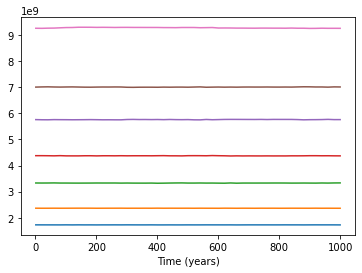

In [14]:
plt.figure()
n = len(states)
times = np.linspace(1, final_time_yr, N_log+1)

for i in range(7):
    params = compute_planet_evolution(i+1, states, masses[0])
    plt.plot(times, params[:,0])
plt.xlabel("Time (years)");
print(n)

Let us also look at the energy conservation and plot it along the simulation, since we only simulated 1000 years in this example, there is not much we can see, but for long term simulation we would see that the Brouwer's law is achieved for the error growth:

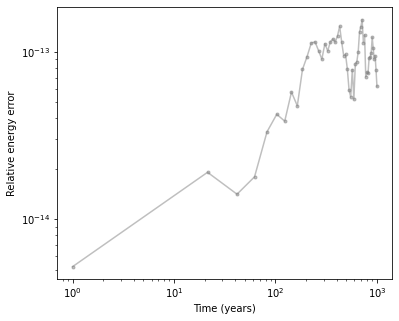

In [15]:
# Error on the energy
DE = []
for i in range(1, len(states)):
    DE.append(-np.abs((energy(states[i], masses) - energy(states[0], masses))) / energy(states[i], masses))
fig = plt.figure(figsize=(6,5))
times = np.linspace(1, final_time_yr, N_log)
plt.loglog(times, DE, alpha=0.5, c='gray', marker='.');

plt.ylabel("Relative energy error");
plt.xlabel("Time (years)");